In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import trange


In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [7]:
dataset=pd.read_pickle('/content/integrators_next_state.pickle')

In [8]:
train_set,test_set=train_test_split(dataset,test_size=0.2)
training_set,validation_set=train_test_split(train_set,test_size=0.2)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.relu1=nn.ReLU()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(output_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.relu1(self.i2h(combined))
        output = self.relu2(self.h2o(hidden))
        output = self.fc(output)
        return output, hidden

    def initHidden(self):
        #return torch.zeros(self.hidden_size).to(device)
        return torch.rand(self.hidden_size).to(device)

In [44]:
EPOCHS   = 5
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
momentum=0.9
batch_size=16
regression_loss_function=nn.MSELoss()
classification_loss_function=nn.CrossEntropyLoss()
n_hidden = 10
dimension=training_set[0][0].size(0)
rnn = RNN(dimension,n_hidden,dimension)
optimizer=optim.SGD(rnn.parameters(),learning_rate,momentum=momentum)

In [45]:
training_losses=[]
validation_losses=[]


for epoch in trange(EPOCHS, desc="Training epoch"):

  rnn.train()

  for batch_start in range(0, len(training_set), batch_size):
    batch_end = min(batch_start + batch_size, len(training_set))
    batch_traces = training_set[batch_start:batch_end]

    optimizer.zero_grad()

    for trace in batch_traces:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct)
        loss_classification = classification_loss_function(classification_output, classification_correct)

        loss = loss_regression + 0.1*loss_classification

        # Accumulate gradients
        loss.backward()

    # Update parameters based on accumulated gradients for the entire batch
    optimizer.step()

  rnn.eval()
  with torch.no_grad():

    training_loss=0

    for trace in training_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        training_loss += loss_regression + 0.1*loss_classification
    training_losses.append(training_loss/len(training_set))

    validation_loss=0

    for trace in validation_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        validation_loss += loss_regression + 0.1*loss_classification
    validation_losses.append(validation_loss/len(validation_set))


Training epoch: 100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


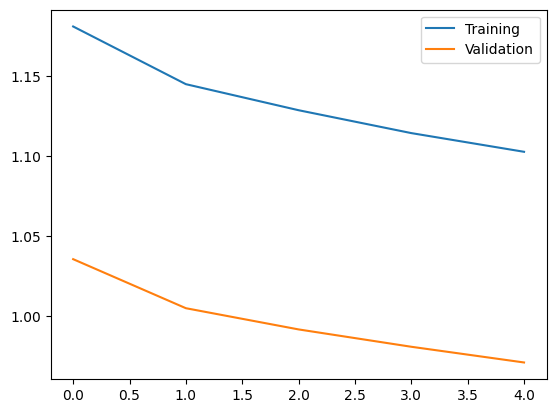

In [46]:
plt.plot(training_losses,label='Training')
plt.plot(validation_losses,label='Validation')
plt.legend()

In [21]:
def evaluate(nn,trace):
    losses_regression=[]
    correct=0
    hidden = nn.initHidden()
    for i in range(len(trace)-1):
        output,hidden=nn(trace[i],hidden)

        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=torch.argmax(output[4:])
        classification_correct=torch.argmax(trace[i+1][4:])

        loss_regression=regression_loss_function(regression_output,regression_correct)
        losses_regression.append(loss_regression)

        if classification_output==classification_correct:
          correct+=1

    return losses_regression,correct


Accuracy is 51.105216622458%
Mean loss is 0.0031049130484461784


(array([735., 219.,  85.,  15.,  10.,  14.,   8.,   2.,   9.,   4.,   2.,
          1.,   3.,   4.,   2.,   0.,   0.,   3.,   4.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([4.12764639e-05, 1.76843116e-03, 3.49558587e-03, 5.22274058e-03,
        6.94989506e-03, 8.67704954e-03, 1.04042049e-02, 1.21313594e-02,
        1.38585139e-02, 1.55856684e-02, 1.73128229e-02, 1.90399773e-02,
        2.07671337e-02, 2.24942882e-02, 2.42214426e-02, 2.59485971e-02,
        2.76757516e-02, 2.9402

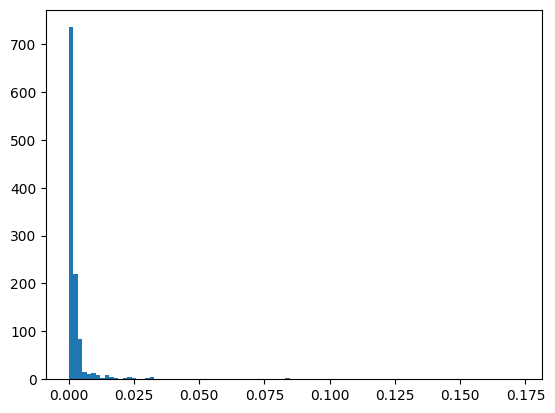

In [22]:
losses=[]
correct=0
tot=0
for trace in test_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

losses=[loss.detach().cpu().numpy() for loss in losses]
print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)

In [ ]:
print(test_set[5])
hidden=rnn.initHidden()
rnn(test_set[5][0],hidden)

tensor([[0.3066, 0.9117, 0.0195, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.2050],
        [0.3066, 0.9117, 0.1543, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2371],
        [0.4188, 0.9117, 0.1543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]])


(tensor([0.4737, 0.8346, 0.2746, 0.2051, 0.1739, 0.1693, 0.1673, 0.1589, 0.6644,
         0.1985, 0.1675, 0.1263], grad_fn=<SigmoidBackward0>),
 tensor([0.5362, 0.5692, 0.4343, 0.5372, 0.5127, 0.5215, 0.4979, 0.5028, 0.5803,
         0.5993], grad_fn=<SigmoidBackward0>))

In [ ]:
def squared_error(input,target):
  return torch.pow(input-target,2)

In [ ]:
class CustomLoss(nn.Module):
  def __init__(self):
        super(CustomLoss, self).__init__()

  def forward(self,input,target):
    mse=(1/4)*(squared_error(input[0],target[0])+squared_error(input[1],target[1])+squared_error(input[2],target[2])+squared_error(input[-1],target[-1]))
    l=torch.zeros(8)
    for i in range(len(l)):
      l[i]=-(target[i]*torch.log(input[i])+(1-target[i])*torch.log(1-input[i]))
    bce=torch.mean(l)
    return 0.5*mse+bce

In [ ]:
l=torch.zeros(3)
l[1]=2
l

tensor([0., 2., 0.])

In [ ]:
train_set[0]

tensor([[0.6102, 0.8874, 0.1609, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1765],
        [0.5267, 0.8874, 0.1609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]], device='cuda:0')